To build the model for TOC.

In [1]:
import numpy as np 
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

# Launch deployment

In [2]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(
    project="aslee@10.110.16.5",
    queue='main',
    cores=20, 
    memory='10 GB',
    walltime="00:20:00",
    log_directory='job_logs'
)

In [45]:
client.close()
cluster.close()

In [3]:
client = Client(cluster)
cluster.scale(100)
#cluster.adapt(maximum=100)

In [5]:
client

Client Scheduler: tcp://10.110.16.11:44035 Dashboard: http://10.110.16.11:8787/status,Cluster Workers: 100 Cores: 400 Memory: 200.00 GB


# Build model for TOC

In [6]:
from dask_ml.model_selection import train_test_split
merge_df = dd.read_csv('data/spe+bulk_dataset_20201008.csv')
X = merge_df.iloc[:, 1: -5].to_dask_array(lengths=True)
X = X / X.sum(axis = 1, keepdims = True)
y = merge_df['TOC%'].to_dask_array(lengths=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 24)

In [7]:
merge_df.columns[-6:]

Index(['2047', 'TC%', 'TOC%', 'CaCO3%', 'core', 'mid_depth_mm'], dtype='object')

In [7]:
X_train

dask.array<from-value, shape=(305, 2048), dtype=float64, chunksize=(305, 2048), chunktype=numpy.ndarray>

In [9]:
y_train

dask.array<from-value, shape=(305,), dtype=float64, chunksize=(305,), chunktype=numpy.ndarray>

## Grid search
We know the relationship between the spectra and bulk measurements might not be linear; and based on the pilot_test.ipynb, the SVR algorithm with NMF transformation provides the better cv score. So we focus on grid search with NMF transformation (4, 5, 6 and 7 components based on the PCA result) and SVR.

In [8]:
%%time
from dask_ml.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(NMF(max_iter = 2000, random_state = 24), SVR())
params = {
    'nmf__n_components': [4, 5, 6, 7],
    'svr__C': np.logspace(0, 7, 8),
    'svr__gamma': np.logspace(-5, 0, 6)
}
grid = GridSearchCV(pipe, param_grid = params, cv = 10, n_jobs = -1)  

grid.fit(X_train, y_train)

print('The best cv score: {:.3f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print('The test score: {:.3f}'.format(grid.best_estimator_.score(X_test, y_test)))
print(grid.best_estimator_)

The best cv score: 0.228
The best parameter: {'nmf__n_components': 7, 'svr__C': 100000.0, 'svr__gamma': 1.0}
The test score: 0.416
Pipeline(steps=[('nmf', NMF(max_iter=2000, n_components=7, random_state=24)),
                ('svr', SVR(C=100000.0, gamma=1.0))])
CPU times: user 12.8 s, sys: 589 ms, total: 13.4 s
Wall time: 19 s


## Try RandomForest

In [10]:
%%time
import joblib
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators = 1000, oob_score = True, n_jobs = -1)

with joblib.parallel_backend('dask'):
    rfr.fit(X_train, y_train)

print('OOB score: {:.3f}'.format(rfr.oob_score_))

OOB score: 0.270
CPU times: user 6.09 s, sys: 1.48 s, total: 7.57 s
Wall time: 8.43 s


In [11]:
rfr.score(X_test, y_test)

0.40198923145465115

## Try GBDT

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(n_estimators = 200, random_state = 24)

with joblib.parallel_backend('dask'):
    reg.fit(X_train, y_train)

In [13]:
reg.score(X_test, y_test)

0.4237084136816952

## Check the results
The scores for TOC are bad, but better than in pilot test. Let's see if we can find reasons. I use the model having the best test score, GBDT, to make discussion.

In [14]:
y_predict = reg.predict(X_test)
y_ttest = np.array(y_test)

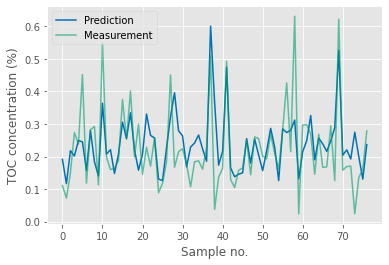

In [15]:
plt.plot(range(len(y_predict)), y_predict, label='Prediction')
plt.plot(range(len(y_predict)), y_ttest, alpha=0.6, label='Measurement')
plt.ylabel('TOC concentration (%)')
plt.xlabel('Sample no.')
plt.legend()
plt.savefig('results/toc_predictions_gbdt_{}.png'.format(date))

In [51]:
y_ttest = np.array(y_test)
y_ttrain = np.array(y_train)

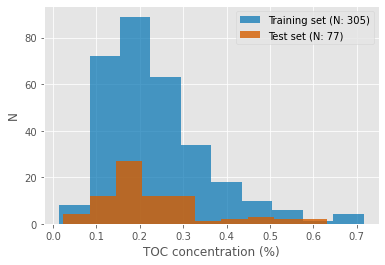

In [52]:
plt.hist(y_ttrain, alpha=.7, label='Training set (N: {})'.format(len(y_ttrain)))
plt.hist(y_ttest, color='C2', alpha=.8, label='Test set (N: {})'.format(len(y_ttest)))
plt.xlabel('TOC concentration (%)')
plt.ylabel('N')
plt.legend()
plt.savefig('results/toc_histogram_{}.png'.format(date))

In [16]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
print('The mean absolute error is {:.3f} (%, concetration).'.format(mean_absolute_error(y_ttest, y_predict)))
print('The max. residual error is {:.3f} (%, concetration).'.format(max_error(y_ttest, y_predict)))

The mean absolute error is 0.067 (%, concetration).
The max. residual error is 0.330 (%, concetration).


The concentraions of TOC are really low, so R2 is easily become very low by its equation. If we use mean residue (i.e. absolute error) as the error measure instead, it only has 0.067 % concentraion in the test set. The max. resedule is only 0.33 %. I think it's under the detection limit of the machine. Therefore, our model is good enough, and due to the consistency and laziness in writting, I'll use the combination of NMF+SVR.

## Redo grid search 

In [17]:
%%time
from dask_ml.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(NMF(max_iter = 2000, random_state = 24), SVR())
params = {
    'nmf__n_components': [4, 5, 6, 7],
    'svr__C': np.logspace(0, 7, 8),
    'svr__gamma': np.logspace(-5, 0, 6)
}
grid = GridSearchCV(pipe, param_grid = params, cv = 10, scoring = 'neg_mean_absolute_error',  n_jobs = -1)  

grid.fit(X_train, y_train)

# it need to be unified back to positive because the GridSearchCV tends to find the "highest" score 
print('The best cv score: {:.3f}'.format(-grid.best_score_)) 
print('The test score: {:.3f}'.format(grid.best_estimator_.score(X_test, y_test)))
print('The best model\'s parameters: {}'.format(grid.best_estimator_))

The best cv score: 0.075
The test score: 0.416
The best model's parameters: Pipeline(steps=[('nmf', NMF(max_iter=2000, n_components=7, random_state=24)),
                ('svr', SVR(C=100000.0, gamma=1.0))])
CPU times: user 16.6 s, sys: 733 ms, total: 17.3 s
Wall time: 21 s


### Visualization

In [18]:
result_df = pd.DataFrame(grid.cv_results_)
result_df.to_csv('results/toc_gridsearch_nmf+svr_{}.csv'.format(date))
#result_df = pd.read_csv('results/gridsearch_nmf+svr_20201009.csv', index_col = 0)
#result_df = result_df[result_df.mean_test_score > -1].reset_index(drop = True)

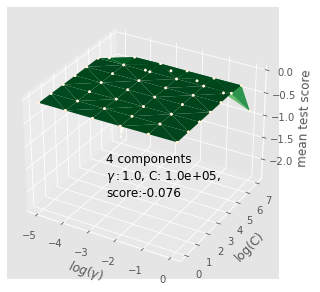

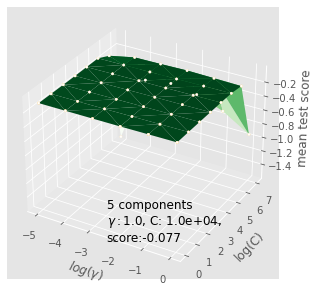

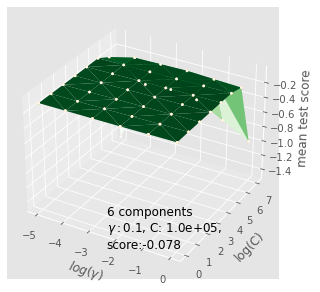

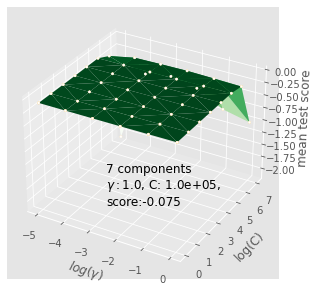

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

for n_components in [4, 5, 6, 7]:
    data = result_df[result_df.param_nmf__n_components == n_components].reset_index(drop = True)
    fig = plt.figure(figsize = (7.3,5))
    ax = fig.gca(projection='3d')
    xx = data.param_svr__gamma.astype(float)
    yy = data.param_svr__C.astype(float)
    zz = data.mean_test_score.astype(float)
    max_index = np.argmax(zz)

    surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap=cm.Greens, linewidth=0.1)
    ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'orange', s = 5)
    # mark the best score
    ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'w', s = 5, alpha = 1)
    text = '{} components\n$\gamma :{:.1f}$, C: {:.1e},\nscore:{:.3f}'.format(n_components, xx[max_index], yy[max_index], zz[max_index])
    ax.text(-3, 1, -2,text, fontsize=12)

    ax.set_xlabel('$log(\gamma)$')
    ax.set_ylabel('log(C)')
    ax.set_zlabel('mean test score')
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    fig.savefig('results/grid_toc_{}nmr+svr_3D_{}.png'.format(n_components, date))
    

Since GridSearchCV tends to find the "highest" score as the best model, and the mean absolute error is the lower the better, the CV score is changed to negative. 

In [20]:
y_predict = grid.best_estimator_.predict(X_test)
y_ttest = np.array(y_test)

In [21]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
print('Scores in the test set:')
print('The mean absolute error is {:.3f} (%, concetration).'.format(mean_absolute_error(y_ttest, y_predict)))
print('The max. residual error is {:.3f} (%, concetration).'.format(max_error(y_ttest, y_predict)))

Scores in the test set:
The mean absolute error is 0.070 (%, concetration).
The max. residual error is 0.362 (%, concetration).


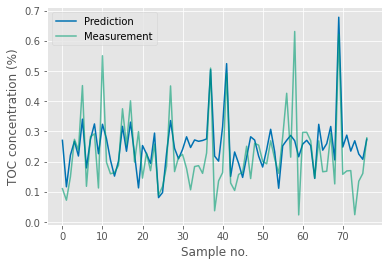

In [22]:
plt.plot(range(len(y_predict)), y_predict, label='Prediction')
plt.plot(range(len(y_predict)), y_ttest, alpha=0.6, label='Measurement')
plt.ylabel('TOC concentration (%)')
plt.xlabel('Sample no.')
plt.legend()
plt.savefig('results/toc_predictions_nmf+svr_{}.png'.format(date))

In [23]:
from joblib import dump, load
#model = load('models/toc_nmf+svr_model_20201012.joblib')
dump(grid.best_estimator_, 'models/toc_nmf+svr_model_{}.joblib'.format(date)) 

['models/toc_nmf+svr_model_20201012.joblib']

The nmf+svr model for TOC using 7 components, C=1e+6 and ${\gamma}$=1 has the mean abslote error in the test set, 0.070 (%, concentration), and the max. residual, 0.362 (%, concentration). Its test score using R2 is 0.416.